오토인코더(Autoencoder)는 입력 데이터를 저차원 잠재 공간(latent space)으로 압축하고, 이를 다시 복원하는 신경망입니다.

입력 데이터를 잠재 공간(latent space)으로 압축한 후, 이를 다시 원래 데이터로 복원하는 비지도 학습 모델입니다.

오토인코더는 입력 데이터와 출력 데이터가 동일한 형태를 갖는 자기 지도 학습(self-supervised learning) 방식으로 학습됩니다. 즉, 입력 데이터를 압축하고 복원하는 과정에서 입력 데이터 자체를 정답(label)으로 사용합니다.

주로 데이터의 특징을 추출하거나, 차원 축소, 이상치 탐지 등에 활용됩니다.


# MNIST 데이터셋(숫자 0~9) 사례

## 라이브러리

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist

## 데이터셋 불러오기

In [ ]:
# MNIST 데이터셋을 로드

In [ ]:
# Keras의 mnist 모듈에서 MNIST 데이터셋을 불러오는 부분입니다.
# MNIST 데이터셋은 0부터 9까지의 손으로 쓴 숫자 이미지 70,000개로 구성된 데이터셋으로,
# 이미지 크기는 28x28 픽셀입니다.
# 이 데이터셋은 주로 이미지 분류 및 신경망 학습 예제에 많이 사용

In [ ]:
# (x_train, _), (x_test, _): mnist.load_data() 함수는 두 개의 튜플을 반환합니다.
#     각 튜플에는 이미지 데이터와 레이블 데이터가 포함되어 있습니다.
# x_train: 학습용 이미지 데이터 (60,000개의 28x28 픽셀 이미지를 포함)
# x_test: 테스트용 이미지 데이터 (10,000개의 28x28 픽셀 이미지를 포함)
# _: 레이블 데이터는 여기서 필요하지 않기 때문에 언더스코어(_)로 받지 않고 무시합니다.
# 오토인코더에서는 레이블을 사용하지 않고 이미지만을 사용해 입력 데이터를 압축하고 복원하기 때문입니다.

In [ ]:
# 데이터셋 불러오기 (MNIST 데이터셋 사용)
(x_train, _), (x_test, _) = mnist.load_data()


## 데이터 전처리

In [ ]:
# 1. 정규화 (Normalization) : 픽셀 값을 0에서 1 사이로 스케일링하여 모델이 학습하기 쉽게 합니다.

In [ ]:
# x_train.astype("float32"): 이미지는 원래 정수형(int)으로 저장되어 있지만, 신경망 모델은 부동 소수점(floating-point) 값을 사용하여 학습하는 것이 일반적이므로, 데이터 타입을 float32로 변환합니다.
# / 255.: 픽셀 값이 0에서 255 사이로 되어 있으므로, 이를 0에서 1 사이로 정규화합니다. 이렇게 하면 모든 픽셀 값이 0~1 범위 내에 들어가게 되어 신경망의 학습이 더 안정적으로 이루어집니다.

In [ ]:
# 2. 형태 변환: 28x28 이미지를 784차원 벡터로 변환하여 오토인코더 모델이 다룰 수 있는 형태로 만듭니다.

In [ ]:
# x_train.shape[1:]는 (28, 28) 크기의 2차원 이미지를 가리킵니다. np.prod(x_train.shape[1:])는 28과 28을 곱하여 784를 얻습니다.
# np.prod(x_train.shape[1:]): shape[1:]의 모든 차원을 곱하여 784라는 값을 얻습니다. 이는 각 이미지를 1차원 벡터로 변환하기 위해 필요한 값입니다.
# .reshape((len(x_train), 784)): reshape를 사용하여 각 이미지를 (28, 28) 형식의 2차원 배열에서 784 차원의 1차원 배열로 변경합니다. 이 과정을 통해 각 이미지는 784개의 연속된 값(픽셀 값)으로 표현됩니다.
# 이 과정을 거치면:

# x_train은 (60000, 784)의 크기를 가지게 됩니다. 즉, 60,000개의 784차원 벡터로 구성된 학습 데이터가 됩니다.
# x_test는 (10000, 784)의 크기를 가지게 됩니다. 즉, 10,000개의 784차원 벡터로 구성된 테스트 데이터가 됩니다.

In [ ]:
# 데이터 전처리
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


## 오토인코더 구조

In [ ]:
# 인코더: 입력 데이터를 32차원의 잠재 공간으로 압축합니다.
# 디코더: 잠재 공간의 데이터를 원래 차원으로 복원합니다.

In [ ]:
# 1. 입력 및 잠재 공간 차원 정의

# input_dim: MNIST 이미지는 (28, 28)의 2차원 배열로 되어 있지만, 이를 784차원의 1차원 벡터로 변환했습니다. 그래서 입력 차원은 784로 설정됩니다.
# encoding_dim: 잠재 공간의 차원을 32로 설정합니다. 이는 입력 데이터가 인코더를 통해 784차원에서 32차원으로 압축된다는 의미입니다. 32는 압축된 표현의 크기를 결정하며, 모델이 32개의 중요한 특징만 남기고 나머지 정보를 버리는 방식으로 데이터를 요약하도록 학습됩니다.

In [ ]:
# 2. 인코더 정의

# input_img = Input(shape=(input_dim,)): 입력 레이어를 정의합니다. 입력의 형태는 input_dim, 즉 784차원으로 설정됩니다.
# encoded = Dense(encoding_dim, activation='relu')(input_img): 인코더 부분에서 Dense 층을 사용하여 784차원의 입력을 32차원으로 줄입니다.
# Dense(encoding_dim): Dense 레이어는 완전 연결 층(fully connected layer)으로, 여기서는 encoding_dim=32의 출력을 가지므로 784차원의 입력이 32차원의 잠재 공간 표현으로 압축됩니다.
# activation='relu': ReLU 활성화 함수는 인코더의 비선형 변환을 제공합니다.

In [ ]:
# 3. 디코더 정의

# decoded = Dense(input_dim, activation='sigmoid')(encoded)
# Dense(input_dim): 디코더 부분에서 Dense 층을 사용하여 32차원의 잠재 공간 표현을 다시 784차원의 원래 차원으로 복원합니다.
# activation='sigmoid': sigmoid 활성화 함수는 출력을 0과 1 사이로 제한합니다.
#     이는 입력 이미지가 0에서 1 사이의 값을 가지므로, 복원된 이미지의 출력도 동일한 범위로 맞추기 위함입니다.

In [ ]:
# 오토인코더 모델 구조 정의
input_dim = x_train.shape[1]  # 입력 차원 (28*28=784)
encoding_dim = 32  # 잠재 공간 차원

# 인코더
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)

# 디코더
decoded = Dense(input_dim, activation='sigmoid')(encoded)

## 오토인코더 모델 정의

In [ ]:
#  오토인코더는 입력 데이터를 압축했다가 복원하는 모델로, 이를 구성하기 위해 세 가지 모델이 사용됩니다:
#         오토인코더 모델, 인코더 모델, 디코더 모델.
# 이렇게 세 가지 모델을 정의함으로써:
# autoencoder를 통해 입력 데이터를 학습하며 전체 오토인코더 모델을 훈련할 수 있고,
# 훈련된 encoder를 사용하여 입력 데이터를 압축된 특징으로 변환할 수 있으며,
# decoder를 사용하여 압축된 특징을 원래 데이터로 복원할 수 있게 됩니다.

In [ ]:
#1. 오토인코더 모델 정의

# Model(input_img, decoded): 전체 오토인코더 모델을 정의합니다. 이 모델은 input_img를 입력으로 받아, decoded를 출력으로 생성하는 구조입니다.
# input_img는 784차원의 원본 입력 데이터이고,
# decoded는 디코더의 최종 출력으로, 입력 이미지를 압축했다가 복원한 결과입니다.
# 따라서, autoencoder 모델은 입력 이미지를 인코더로 압축한 후, 디코더로 복원하여 원본에 가까운 출력을 만들어내는 모델입니다.
# 오토인코더를 학습할 때는 이 autoencoder 모델을 사용하게 됩니다.

In [ ]:
# 2. 인코더 모델 정의 (압축된 표현을 얻기 위해)

# Model(input_img, encoded): 인코더 모델만 따로 정의하여 입력 데이터를 압축된 표현으로 변환할 수 있게 합니다.
# input_img는 784차원의 원본 입력 데이터입니다.
# encoded는 인코더의 출력으로, 784차원의 입력 데이터가 32차원의 잠재 공간 표현으로 압축된 결과입니다.
# 이 encoder 모델은 오토인코더의 첫 번째 절반만을 포함하며, 이를 통해 원본 데이터를 압축한 잠재 공간 표현을 얻을 수 있습니다.

In [ ]:
# 3. 디코더 모델 정의 (잠재 공간에서 원래 데이터를 복원)

# encoded_input = Input(shape=(encoding_dim,)): 디코더의 입력 레이어를 정의합니다. 인코더가 압축하여 출력한 32차원 잠재 공간 표현을 입력으로 받습니다.
# decoder_layer = autoencoder.layers[-1]: autoencoder 모델의 마지막 레이어, 즉 디코더의 복원 레이어를 가져옵니다. 디코더의 핵심인 복원 작업을 수행하는 레이어를 가져와서 디코더 모델을 구성합니다.
# decoder = Model(encoded_input, decoder_layer(encoded_input)): 디코더 모델을 정의하여, 압축된 잠재 공간 표현을 다시 원래의 784차원으로 복원할 수 있게 합니다.

In [ ]:
# 오토인코더 모델 정의
autoencoder = Model(input_img, decoded)

# 인코더 모델 정의 (압축된 표현을 얻기 위해)
encoder = Model(input_img, encoded)

# 디코더 모델 정의 (잠재 공간에서 원래 데이터를 복원)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


## 모델 컴파일

In [ ]:
# 오토인코더 모델을 컴파일하는 부분입니다.
# 컴파일 과정에서는 최적화 알고리즘과 손실 함수를 지정하여 모델의 학습 방식을 설정합니다.

In [ ]:
# optimizer='adam': 최적화 알고리즘으로 **Adam(Adaptive Moment Estimation)**을 사용합니다.
#     # Adam은 경사 하강법을 개선한 알고리즘으로, 학습 속도가 빠르고 효율적이기 때문에 널리 사용됩니다.
#     # 특히 학습 속도를 자동으로 조정해주는 특성이 있어, 오토인코더 같은 신경망 모델의 최적화에 효과적입니다.

# loss='binary_crossentropy': 손실 함수로 binary cross-entropy(이진 교차 엔트로피)를 사용합니다.
#     오토인코더의 경우, 출력이 입력과 동일하도록 재구성(reconstruction)해야 하는데,
#     이때 픽셀 값이 0과 1 사이의 범위로 정규화된 이미지 데이터를 다루므로 binary cross-entropy가 적합합니다.

In [ ]:
# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## 훈련

In [ ]:
# 오토인코더는 입력 데이터와 출력 데이터가 동일한 형태를 갖는 자기 지도 학습(self-supervised learning) 방식으로 학습됩니다.
# 즉, 입력 데이터를 압축하고 복원하는 과정에서 입력 데이터 자체를 정답(label)으로 사용합니다.

In [ ]:
# x_train, x_train: 입력과 출력으로 동일한 x_train을 사용합니다.
# 오토인코더는 입력 데이터를 압축한 후 복원해 원본과 최대한 비슷하게 만드는 것을 목표로 하기 때문에, x_train이 입력이자 정답이 됩니다.

# epochs=50: 학습 횟수를 50번으로 설정합니다.
# 한 에포크(epoch)는 전체 데이터셋을 한 번 학습하는 주기를 의미합니다.
# 50번 동안 데이터셋을 반복 학습하여 모델이 점점 더 정교하게 입력을 복원하도록 만듭니다.

# batch_size=256: 배치 크기를 256으로 설정합니다.
# 즉, 한 번에 256개의 샘플을 처리하여 가중치를 업데이트합니다.
# 배치 크기는 메모리 사용량과 학습 속도에 영향을 미치며, GPU 사용 시 일반적으로 32, 64, 128, 256 등의 배치 크기를 사용합니다.

# shuffle=True: 에포크마다 데이터셋을 섞어서 학습합니다.
# 이는 모델이 데이터의 순서에 의존하지 않도록 하여 더 일반화된 학습이 이루어지도록 돕습니다.

# validation_data=(x_test, x_test): 검증 데이터로 x_test를 사용합니다.
# 훈련 데이터와 마찬가지로, 입력과 출력이 동일한 x_test를 사용해 모델의 성능을 평가합니다.
# 각 에포크 후에 검증 데이터셋에서의 성능을 확인하여, 모델이 과적합(overfitting) 없이 잘 학습하고 있는지 모니터링할 수 있습니다.

In [ ]:
# 모델 학습
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


In [ ]:
#  오토인코더는 인코더와 디코더로 나뉘어 있으므로, 입력 데이터를 인코더를 통해 압축된 표현(latent representation)으로 변환하고,
#     이를 다시 디코더를 통해 원본에 가까운 이미지로 복원할 수 있습니다.

## 인코딩과 디코딩

In [ ]:
# 1. 압축된 표현 얻기 (인코딩)

# encoder.predict(x_test): 테스트 데이터셋 x_test를 인코더 모델에 입력하여 압축된 표현을 얻습니다.
# encoded_imgs: 인코더를 통과한 결과로, 각 이미지가 원래의 784차원에서 32차원으로 압축된 표현이 됩니다.
# 이 encoded_imgs는 잠재 공간(latent space) 표현이며, 입력 데이터의 주요 특징만을 간추린 정보입니다.

In [ ]:
# 2. 복원된 이미지 얻기 (디코딩)

# decoder.predict(encoded_imgs): 압축된 표현인 encoded_imgs를 디코더 모델에 입력하여 복원된 이미지를 얻습니다.
# decoded_imgs: 디코더를 통과한 결과로, 32차원 잠재 공간 표현이 다시 784차원의 원래 이미지 형태로 복원됩니다.
#     이는 입력 이미지와 유사하지만 완전히 동일하지는 않습니다. 오토인코더는 압축하면서 일부 정보를 잃기 때문입니다.

In [ ]:

# 압축된 표현 얻기 (인코딩)
encoded_imgs = encoder.predict(x_test)

# 복원된 이미지 얻기 (디코딩)
decoded_imgs = decoder.predict(encoded_imgs)


## 결과 시각화

In [ ]:
#원본 이미지와 복원된 이미지를 시각화하여 오토인코더의 성능을 확인합니다.

In [ ]:
# 1. 전체 시각화 설정

# n = 10: 원본 이미지와 복원된 이미지 각각 10개씩을 표시합니다.
# plt.figure(figsize=(20, 4)): 그래프 크기를 설정합니다. 전체적인 가로와 세로 크기를 (20, 4)로 지정하여 이미지를 크게 볼 수 있도록 합니다.

In [ ]:
# 2. 원본 이미지 표시

# plt.subplot(2, n, i + 1): 총 2 x n 배열의 서브플롯을 만들고, 원본 이미지를 첫 번째 행에 표시합니다. i + 1은 순서를 지정합니다.
# plt.imshow(x_test[i].reshape(28, 28)): 원본 이미지를 28x28 크기로 다시 변형하여 표시합니다.
# plt.gray(): 이미지를 회색조로 설정합니다.
# ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False): 축 눈금을 보이지 않게 설정하여 깔끔한 이미지만 표시합니다.

In [ ]:
# 3. 복원된 이미지 표시

# plt.subplot(2, n, i + 1 + n): 복원된 이미지를 두 번째 행에 표시합니다. i + 1 + n은 복원 이미지를 두 번째 행에 배치하기 위해 인덱스를 조정합니다.
# plt.imshow(decoded_imgs[i].reshape(28, 28)): 복원된 이미지를 28x28 크기로 다시 변형하여 표시합니다.

In [ ]:
# 4. 결과 표시

# plt.show(): 설정된 이미지들을 화면에 출력합니다.

In [ ]:
# 결과 시각화
import matplotlib.pyplot as plt

n = 10  # 이미지 개수
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 복원된 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


코드 종합

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3818 - val_loss: 0.1909
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1806 - val_loss: 0.1529
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1484 - val_loss: 0.1330
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1308 - val_loss: 0.1212
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1201 - val_loss: 0.1135
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1133 - val_loss: 0.1078
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1081 - val_loss: 0.1037
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1041 - val_loss: 0.1004
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1010 - val_loss: 0.0978
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0987 - val_loss: 0.0959
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0969 - val_loss: 0.0947
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

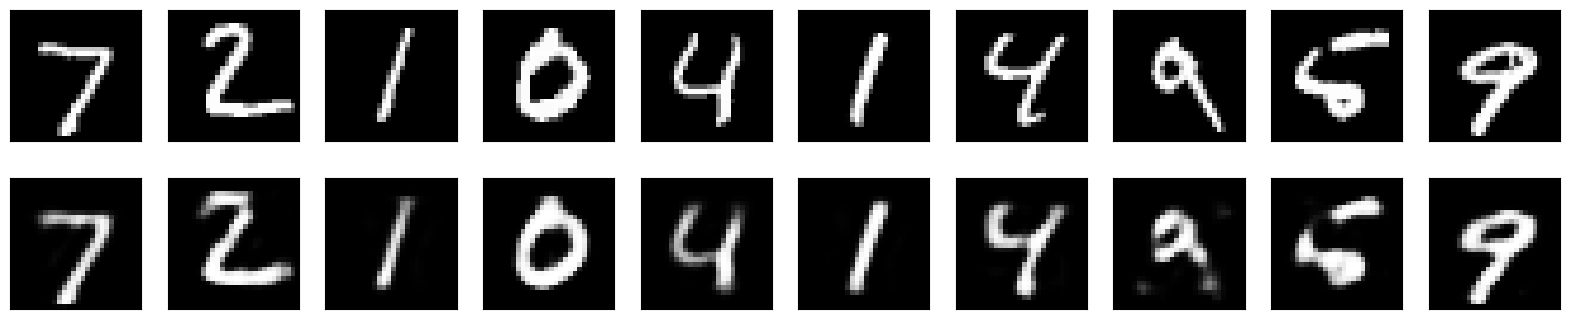

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist

# 데이터셋 불러오기 (MNIST 데이터셋 사용)
(x_train, _), (x_test, _) = mnist.load_data()

# 데이터 전처리
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# 오토인코더 모델 구조 정의
input_dim = x_train.shape[1]  # 입력 차원 (28*28=784)
encoding_dim = 32  # 잠재 공간 차원

# 인코더
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)

# 디코더
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# 오토인코더 모델 정의
autoencoder = Model(input_img, decoded)

# 인코더 모델 정의 (압축된 표현을 얻기 위해)
encoder = Model(input_img, encoded)

# 디코더 모델 정의 (잠재 공간에서 원래 데이터를 복원)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 학습
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

# 압축된 표현 얻기 (인코딩)
encoded_imgs = encoder.predict(x_test)

# 복원된 이미지 얻기 (디코딩)
decoded_imgs = decoder.predict(encoded_imgs)

# 결과 시각화
import matplotlib.pyplot as plt

n = 10  # 이미지 개수
plt.figure(figsize=(20, 4))
for i in range(n):
    # 원본 이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 복원된 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# 이상치 탐지 사례

In [ ]:
# 오토인코더를 활용한 이상치 탐지 예제입니다. 오토인코더는 정상 데이터를 학습한 후,
# 모든 데이터에 대해 재구성 오류를 계산하고,
# 오류가 큰 데이터(즉, 잘 복원되지 않는 데이터)를 이상치로 분류합니다

## 라이브로리

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

 ## 데이터 생성

In [ ]:
# normal_data: 평균이 0, 표준편차가 1인 정규분포에서 1000개의 정상 데이터를 생성합니다.
# anomalous_data: 평균이 5, 표준편차가 1인 정규분포에서 100개의 이상치 데이터를 생성합니다. 정상 데이터와 평균값이 다르므로 이상치로 간주됩니다.
# data: 정상 데이터와 이상치를 합쳐서 전체 데이터셋을 만들고, 섞어(shuffle)줍니다.

In [ ]:
# 임의의 데이터 생성 (정상 데이터와 이상치 데이터)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 20))  # 평균 0, 표준편차 1
anomalous_data = np.random.normal(loc=5.0, scale=1.0, size=(100, 20))  # 평균 5, 표준편차 1 (이상치)

# 데이터 병합
data = np.concatenate([normal_data, anomalous_data], axis=0)
np.random.shuffle(data)

## 오토인코더 모델 정의

In [ ]:
# input_dim: 입력 차원은 20입니다.
# encoding_dim: 잠재 공간 차원은 10으로 설정합니다.
# input_layer부터 encoded와 decoded까지의 레이어를 쌓아 오토인코더 모델을 정의합니다.

In [ ]:
# 오토인코더 모델 정의
input_dim = data.shape[1]
encoding_dim = 10  # 잠재 공간 차원

# 인코더
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# 디코더
decoded = Dense(input_dim, activation='sigmoid')(encoded)
# 오토인코더 모델
autoencoder = Model(input_layer, decoded)

## 모델 컴파일 및 학습

In [ ]:
# 손실 함수로 mse(Mean Squared Error, 평균 제곱 오차)를 사용하여 입력과 재구성된 데이터 간의 차이를 최소화하도록 학습합니다.
# 정상 데이터(normal_data)만을 사용해 오토인코더를 훈련합니다.
# 이렇게 하면 정상 데이터의 특성만 학습하게 되어, 이상치는 재구성 오류가 크게 나타납니다.

In [ ]:
# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 정상 데이터만으로 모델 훈련
autoencoder.fit(normal_data, normal_data,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1)

## 재구성 오류 계산

In [ ]:
# 재구성 오류는 각 샘플에 대해 (입력 데이터 - 복원된 데이터)^2의 평균으로 계산됩니다.
# 재구성 오류가 작으면 정상 데이터로 볼 수 있으며, 크면 이상치로 간주할 수 있습니다.

In [ ]:
# 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - reconstructed_data, 2), axis=1)


## 이상치 탐지를 위한 임계값 설정

In [ ]:
# 재구성 오류의 상위 5%에 해당하는 값을 **임계값(threshold)**로 설정합니다.
# 이 값을 초과하는 데이터는 이상치로 간주합니다.

In [ ]:
# 이상치 탐지를 위한 임계값 설정 (재구성 오류가 큰 데이터는 이상치로 판단)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 설정

## 이상치 판별

In [ ]:
# 재구성 오류가 임계값을 초과하는 데이터를 이상치로 분류합니다.

In [ ]:
# 이상치와 정상 데이터 분류
anomalies = reconstruction_error > threshold

## 결과 시각화 및 출력

In [ ]:
# 재구성 오류 히스토그램을 그려서 임계값을 시각적으로 확인합니다.
# 임계값을 초과하는 데이터 수를 이상치로 판별하여 출력합니다.

In [ ]:
# 결과 시각화
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Detected anomalies: {np.sum(anomalies)} out of {data.shape[0]} samples")


코드 종합

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2571 - val_loss: 1.2723
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2332 - val_loss: 1.2318
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1753 - val_loss: 1.1947
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1412 - val_loss: 1.1600
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1373 - val_loss: 1.1276
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0808 - val_loss: 1.0987
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0626 - val_loss: 1.0729
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0388 - val_loss: 1.0495
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0126 - val_loss: 1.0294
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0133 - val_loss: 1.0120
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9652 - val_loss: 0.9970
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9835 - val_l

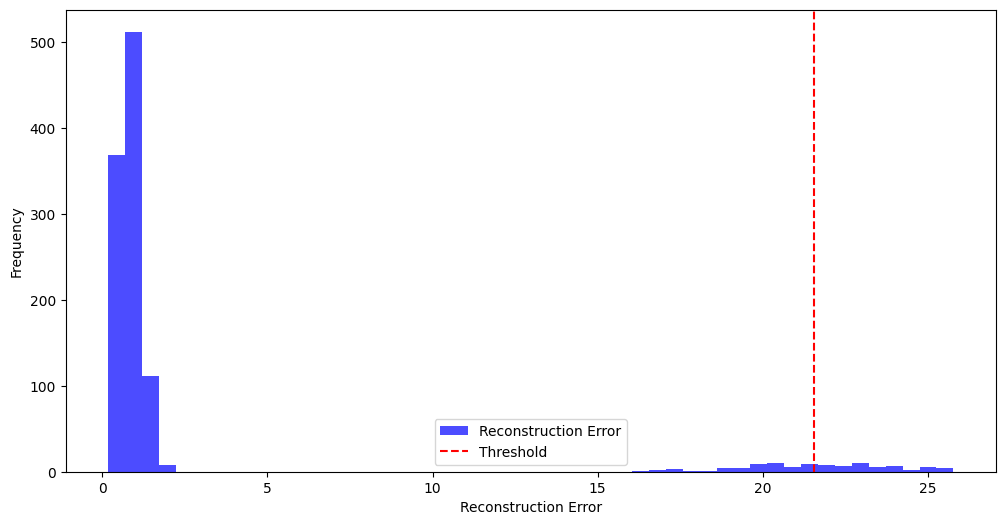

Detected anomalies: 55 out of 1100 samples


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# 임의의 데이터 생성 (정상 데이터와 이상치 데이터)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 20))  # 평균 0, 표준편차 1
anomalous_data = np.random.normal(loc=5.0, scale=1.0, size=(100, 20))  # 평균 5, 표준편차 1 (이상치)

# 데이터 병합
data = np.concatenate([normal_data, anomalous_data], axis=0)
np.random.shuffle(data)

# 오토인코더 모델 정의
input_dim = data.shape[1]
encoding_dim = 10  # 잠재 공간 차원

# 인코더
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# 디코더
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# 오토인코더 모델
autoencoder = Model(input_layer, decoded)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 정상 데이터만으로 모델 훈련
autoencoder.fit(normal_data, normal_data,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1)

# 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - reconstructed_data, 2), axis=1)

# 이상치 탐지를 위한 임계값 설정 (재구성 오류가 큰 데이터는 이상치로 판단)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 설정

# 이상치와 정상 데이터 분류
anomalies = reconstruction_error > threshold

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Detected anomalies: {np.sum(anomalies)} out of {data.shape[0]} samples")


In [ ]:
# 결과 해석
# 재구성 오류가 높으면, 모델이 입력 데이터를 정상적인 범위로 잘 복원하지 못했음을 의미하며, 이를 이상치로 판단할 수 있습니다.
# 이 방법은 주로 이상 탐지 문제에서 사용되며, 정상 데이터로 훈련된 오토인코더가 이상 데이터를 잘 재구성하지 못하는 점을 활용합니다.

In [ ]:
# 1. 재구성 오류 히스토그램
# 히스토그램은 재구성 오류의 분포를 시각화한 것입니다.

# X축: 재구성 오류 (Reconstruction Error). 이는 입력 데이터와 오토인코더가 복원한 데이터 간의 차이를 나타냅니다.
# Y축: 오류 범위에 해당하는 데이터 포인트의 빈도수.
# 파란색 막대: 오류 값의 분포를 나타냅니다. 대부분의 데이터는 작은 오류를 가지고 있지만, 일부 데이터는 큰 오류를 나타냅니다.
# 빨간색 점선 (임계값): 이 선은 threshold = np.percentile(reconstruction_error, 95)에 의해 설정된 임계값으로, 재구성 오류가 상위 5%인 데이터를 기준으로 설정되었습니다.

# 해석:
# 임계값을 초과하는 데이터 포인트는 이상치로 간주됩니다.
# 히스토그램을 보면, 대부분의 정상 데이터는 임계값 이하의 재구성 오류를 가지고 있습니다.
# 하지만 정상 데이터와 상당히 다른 이상치 데이터는 큰 재구성 오류를 가지며, 임계값을 초과한 부분에 위치하게 됩니다.

# 2. 출력된 이상치의 개수
# print(f"Detected anomalies: {np.sum(anomalies)} out of {data.shape[0]} samples")

# Detected anomalies: 55 out of 1100 samples

# 이 출력문은 이상치로 판별된 데이터의 개수를 보여줍니다.
# np.sum(anomalies): 이상치로 판별된 데이터의 개수를 계산합니다.
# data.shape[0]: 전체 데이터의 개수입니다.
# 해석:
# 출력된 숫자는 오토인코더가 재구성 오류를 기준으로 이상치로 분류한 데이터의 수입니다.
# 예를 들어, Detected anomalies: 50 out of 1100 samples라는 결과가 나왔다면, 전체 데이터 1100개 중에서 50개가 이상치로 탐지되었다는 의미입니다. 이 중 이상치 데이터(100개 중 일부 또는 전체)가 포함되었을 가능성이 높습니다.
# 전반적인 결과 해석
# 오토인코더는 정상 데이터만으로 학습되었기 때문에 정상 데이터에 대한 재구성 오류는 낮게 나타나며, 오토인코더가 학습하지 않은 이상치 데이터는 높은 재구성 오류를 보입니다.
# 이 높은 재구성 오류를 기준으로 오토인코더는 이상치 데이터를 잘 판별할 수 있게 되며, 임계값을 초과하는 데이터 포인트가 이상치로 분류됩니다.

# 이상치 데이터를 제거 후, 남은 데이터로 다시 오토인코더를 학습

In [ ]:
# 코드 설명
# 이상치 제거:

# anomalies 배열을 사용하여, 이상치가 아닌 데이터를 cleaned_data에 저장합니다.
# cleaned_data = data[~anomalies]는 이상치를 제거한 후의 데이터로, 재학습에 사용됩니다.
# 오토인코더 모델 재학습:

# 이상치를 제거한 후의 데이터를 이용하여 오토인코더를 다시 학습합니다.
# 재구성 오류 시각화:

# 재학습된 모델의 재구성 오류를 시각화하여, 이상치가 제거된 후의 데이터에서 재구성 오류가 어떻게 분포되는지 확인할 수 있습니다.

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2396 - val_loss: 1.1822
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2001 - val_loss: 1.1492
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1449 - val_loss: 1.1173
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1410 - val_loss: 1.0872
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0864 - val_loss: 1.0589
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0805 - val_loss: 1.0322
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0461 - val_loss: 1.0074
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0065 - val_loss: 0.9850
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9973 - val_loss: 0.9655
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9856 - val_loss: 0.9485
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9549 - val_loss: 0.9336
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9494 - val_l

Epoch 19/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5630 - val_loss: 1.7376
Epoch 20/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5678 - val_loss: 1.7360
Epoch 21/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4526 - val_loss: 1.7344
Epoch 22/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3975 - val_loss: 1.7336
Epoch 23/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5322 - val_loss: 1.7331
Epoch 24/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4716 - val_loss: 1.7314
Epoch 25/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2826 - val_loss: 1.7151
Epoch 26/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3705 - val_loss: 1.7121
Epoch 27/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3725 - val_loss: 1.7112
Epoch 28/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3857 - val_loss: 1.7108
Epoch 29/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5403 - val_loss: 1.7106
Epoch 30/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2487

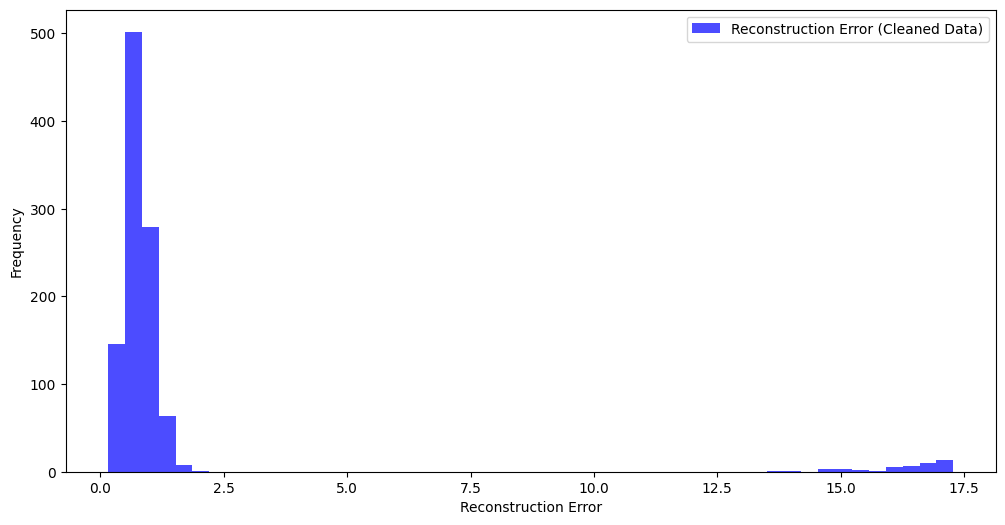

Model retrained with cleaned data. Remaining samples: 1045


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# 1. 임의의 데이터 생성 (정상 데이터와 이상치 데이터)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=(1000, 20))  # 평균 0, 표준편차 1
anomalous_data = np.random.normal(loc=5.0, scale=1.0, size=(100, 20))  # 평균 5, 표준편차 1 (이상치)

# 데이터 병합 및 섞기
data = np.concatenate([normal_data, anomalous_data], axis=0)
np.random.shuffle(data)

# 2. 오토인코더 모델 정의
input_dim = data.shape[1]
encoding_dim = 10  # 잠재 공간 차원

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)

# 3. 모델 컴파일 및 초기 학습 (정상 데이터로만)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(normal_data, normal_data,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1)

# 4. 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(data)
reconstruction_error = np.mean(np.power(data - reconstructed_data, 2), axis=1)

# 5. 임계값 설정 및 이상치 식별
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 설정
anomalies = reconstruction_error > threshold  # 이상치로 판별된 데이터

# 6. 이상치 제거
cleaned_data = data[~anomalies]  # 이상치를 제외한 정상 데이터만 추출
print(f"Number of samples after removing anomalies: {cleaned_data.shape[0]}")

# 7. 오토인코더 모델 재학습 (이상치 제거 후 데이터로)
autoencoder.fit(cleaned_data, cleaned_data,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1)

# 8. 재구성 오류 시각화 (이상치 제거 후)
reconstructed_data_cleaned = autoencoder.predict(cleaned_data)
reconstruction_error_cleaned = np.mean(np.power(cleaned_data - reconstructed_data_cleaned, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.hist(reconstruction_error_cleaned, bins=50, color='blue', alpha=0.7, label='Reconstruction Error (Cleaned Data)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Model retrained with cleaned data. Remaining samples: {cleaned_data.shape[0]}")


In [ ]:
# Model retrained with cleaned data. Remaining samples: 1045

In [ ]:
# 결과 해석
# 이렇게 이상치를 제거하고 남은 데이터로 다시 오토인코더를 학습함으로써,
# 데이터에서 이상치의 영향을 최소화하여 보다 깨끗한 데이터로 모델을 훈련할 수 있게 됩니다.

# 삼성전자 일별data 이상치 탐지

In [ ]:
# yfinance 라이브러리를 이용하여 삼성전자의 일별 주가 데이터를 불러온 후, 오토인코더를 사용하여 이상치 탐지를 수행하는 예시를 보여드립니다.
# 이 예제는 종가(Close) 데이터에 기반하여 이상치를 탐지하는 방식

[*********************100%***********************]  1 of 1 completed


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 1.2045 - val_loss: 1.3065
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1292 - val_loss: 1.2893
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1263 - val_loss: 1.2723
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0876 - val_loss: 1.2546
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1249 - val_loss: 1.2372
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0679 - val_loss: 1.2203
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0219 - val_loss: 1.2029
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0161 - val_loss: 1.1852
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0494 - val_loss: 1.1670
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1078 - val_loss: 1.1494
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0730 - val_loss: 1.1326
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0713 - val_l

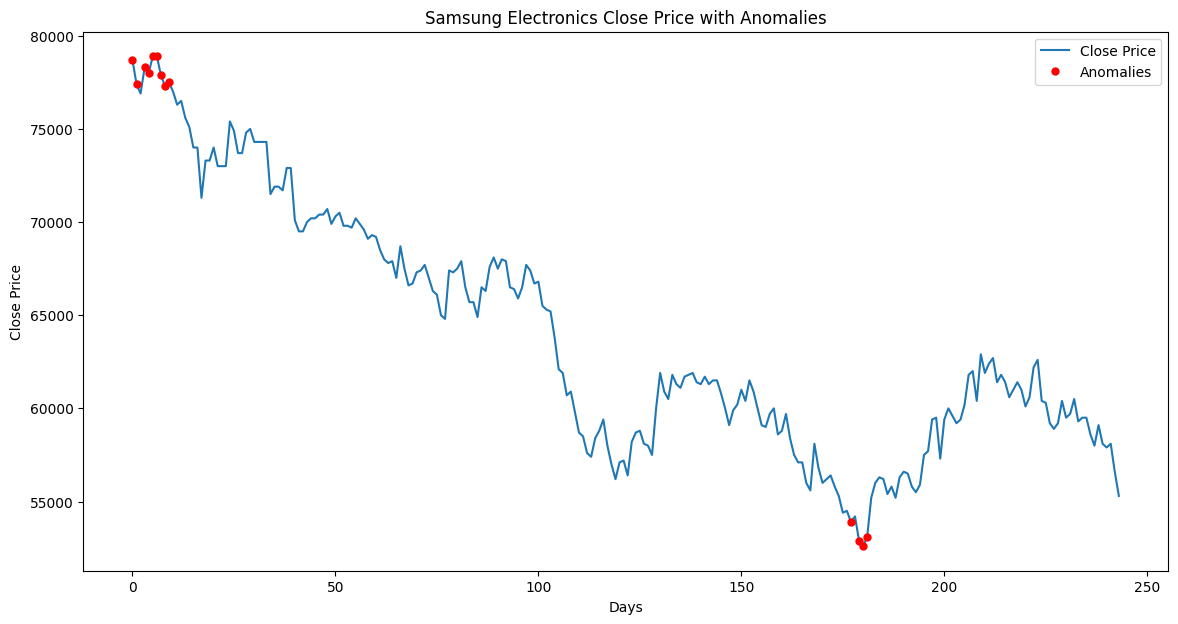

Detected anomalies: 13 out of 244 data points


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# 1. 삼성전자 데이터 불러오기
ticker = '005930.KS'  # 삼성전자 코스피 티커
data = yf.download(ticker, start="2022-01-01", end="2023-01-01", interval="1d")#yfinance의 tz_localize 에러를 방지하는 코드 변경
close_prices = data[['Close']].values  # 종가 데이터만 선택

# 데이터 정규화 (이상 탐지 모델에 입력으로 적합하게 하기 위해)
mean = close_prices.mean()
std = close_prices.std()
normalized_data = (close_prices - mean) / std

# 2. 오토인코더 모델 정의
input_dim = normalized_data.shape[1]
encoding_dim = 1  # 잠재 공간 차원 (단일 변수이므로 1차원으로 압축)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)

# 3. 모델 컴파일 및 학습
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(normalized_data, normalized_data,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.1)

# 4. 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(normalized_data)
reconstruction_error = np.mean(np.power(normalized_data - reconstructed_data, 2), axis=1)

# 5. 이상치 탐지를 위한 임계값 설정 (재구성 오류가 큰 데이터는 이상치로 판단)
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 설정
anomalies = reconstruction_error > threshold  # 이상치로 분류된 데이터

# 6. 이상치 탐지 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(close_prices, label='Close Price')
plt.plot(np.where(anomalies)[0], close_prices[anomalies], 'ro', markersize=5, label='Anomalies')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Samsung Electronics Close Price with Anomalies')
plt.legend()
plt.show()

print(f"Detected anomalies: {np.sum(anomalies)} out of {len(close_prices)} data points")


In [ ]:
# 그래프 시각화 결과
# 파란색 선: 삼성전자의 일별 **종가(Close)**를 나타냅니다.
# 빨간색 점: 이상치로 탐지된 날의 주가입니다. 이는 오토인코더가 복원한 주가 데이터와 실제 주가 데이터의 차이가 크다는 뜻입니다.
#     즉, 이 날짜의 주가는 일반적인 패턴에서 벗어난 것으로 판단됩니다.

In [ ]:
# 탐지된 이상치 개수 출력
# Detected anomalies: X out of Y data points라는 메시지는 전체 데이터 포인트(Y) 중에서 X개가 이상치로 탐지되었음을 의미합니다.
# 예를 들어, Detected anomalies: 15 out of 250 data points라는 결과는 전체 250개의 주가 데이터 중에서 15개가 이상치로 판별되었음을 나타냅니다.

# 정상 데이터로 오토인코더 모델을 다시 학습하는 과정

In [ ]:
# 이상치 탐지 및 제거:

# anomalies 배열을 통해 이상치를 분류하고, 이를 제외한 데이터를 cleaned_data에 저장합니다.
# cleaned_data = normalized_data[~anomalies]는 이상치가 아닌 데이터만 추출한 결과입니다.
# 오토인코더 모델 재학습:

# 이상치를 제거한 후 남은 정상 데이터로 오토인코더 모델을 다시 학습합니다.
# 재구성 오류 시각화:

# 이상치 제거 후 모델의 재구성 오류를 시각화하여, 데이터가 깨끗해진 후 재구성 오류가 어떻게 변했는지 확인합니다.

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 1.4319 - val_loss: 1.4447
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3912 - val_loss: 1.4373
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3539 - val_loss: 1.4298
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2291 - val_loss: 1.4226
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4622 - val_loss: 1.4148
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4023 - val_loss: 1.4077
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2448 - val_loss: 1.4008
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4041 - val_loss: 1.3933
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4038 - val_loss: 1.3864
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3167 - val_loss: 1.3800
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2766 - val_loss: 1.3734
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2717 - val_loss: 1.3666

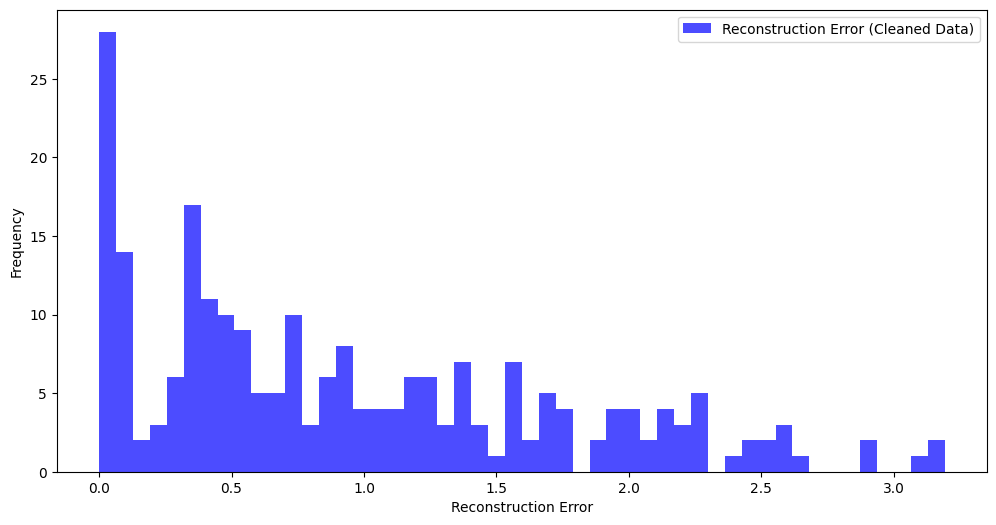

Model retrained with cleaned data. Remaining samples: 231


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

# 1. 삼성전자 데이터 불러오기
ticker = '005930.KS'  # 삼성전자 코스피 티커
data = yf.download(ticker, start='2022-01-01', end='2023-01-01')
close_prices = data[['Close']].values  # 종가 데이터만 선택

# 데이터 정규화 (이상 탐지 모델에 입력으로 적합하게 하기 위해)
mean = close_prices.mean()
std = close_prices.std()
normalized_data = (close_prices - mean) / std

# 2. 오토인코더 모델 정의
input_dim = normalized_data.shape[1]
encoding_dim = 1  # 잠재 공간 차원 (단일 변수이므로 1차원으로 압축)

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)

# 3. 모델 컴파일 및 학습 (초기 학습)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(normalized_data, normalized_data,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.1)

# 4. 모든 데이터에 대해 재구성 오류 계산
reconstructed_data = autoencoder.predict(normalized_data)
reconstruction_error = np.mean(np.power(normalized_data - reconstructed_data, 2), axis=1)

# 5. 이상치 탐지를 위한 임계값 설정 및 이상치 제거
threshold = np.percentile(reconstruction_error, 95)  # 상위 5%를 이상치로 설정
anomalies = reconstruction_error > threshold  # 이상치로 분류된 데이터
cleaned_data = normalized_data[~anomalies]  # 이상치를 제외한 정상 데이터만 추출

print(f"Number of samples after removing anomalies: {cleaned_data.shape[0]}")

# 6. 이상치 제거 후 모델 재학습
autoencoder.fit(cleaned_data, cleaned_data,
                epochs=50,
                batch_size=16,
                shuffle=True,
                validation_split=0.1)

# 7. 재구성 오류 시각화 (이상치 제거 후)
reconstructed_data_cleaned = autoencoder.predict(cleaned_data)
reconstruction_error_cleaned = np.mean(np.power(cleaned_data - reconstructed_data_cleaned, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.hist(reconstruction_error_cleaned, bins=50, color='blue', alpha=0.7, label='Reconstruction Error (Cleaned Data)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Model retrained with cleaned data. Remaining samples: {cleaned_data.shape[0]}")


In [ ]:
# Number of samples after removing anomalies: 231라고 출력되었다면, 원래 데이터 243개에서 13개의 이상치가 제거되어 231개의 정상 데이터만 남았다는 의미입니다.

# 재구성 오류 히스토그램
# plt.hist(reconstruction_error_cleaned, ...)를 통해 시각화된 히스토그램은 이상치 제거 후 재구성 오류의 분포를 보여줍니다.
# X축은 재구성 오류 값이며, Y축은 해당 오류 값을 가진 데이터의 빈도입니다.
# 이상치가 제거된 후 재구성 오류가 작아진 범위에서 분포하게 됩니다.

# 해석:
# 이상치 데이터가 제거되었기 때문에, 전체적인 재구성 오류의 범위가 좁아지고, 오류 값이 상대적으로 낮은 구간에 더 많은 데이터가 분포하게 됩니다.
# 이전보다 오류 값이 작고 고르게 분포된 모습을 보인다면, 오토인코더 모델이 정상 데이터의 특성을 더 잘 학습하여 원본 데이터에 가까운 복원을 수행하고 있다는 의미입니다.
# 오토인코더 재학습 후 성능 개선
# 이상치가 포함된 데이터는 오토인코더가 데이터의 정상 패턴을 학습하는 것을 방해할 수 있습니다.
# 이상치를 제거한 후 정상 데이터로 다시 학습함으로써, 오토인코더가 정상 패턴을 더 정확히 학습하게 됩니다.
# 재학습 후 재구성 오류가 줄어들면, 오토인코더가 입력 데이터를 더 잘 복원할 수 있음을 나타내며, 모델의 성능이 향상되었음을 의미합니다.